In [167]:
#%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from pandas.core.common import flatten
import copy
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as imgmp
import shutil

import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
from timm import create_model

import albumentations as A
import cv2
import glob
import os
import shapely.geometry as sg
import shapely.ops as so
import colorsys
import requests
import glob
import samgeo
import leafmap
import json

from skimage import io #, transform

from tqdm import tqdm
from shapely import wkt
from shapely.geometry import mapping, Polygon, box

from torchvision import datasets, models #, transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from samgeo import SamGeo, tms_to_geotiff, get_basemaps
from rasterio.plot import show
from rasterio.mask import mask
from transformers import ViTModel
from osgeo import gdal
from transformers import ViTForImageClassification, ViTImageProcessor
from os import listdir
from os.path import isfile, join
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from pathlib import Path
from torchvision.transforms import ToTensor

In [40]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


Notes:


- Used the following instead of pip conda install -c huggingface -c conda-forge datasets

### Data Prep

### Create Transformations

Below is the code for transformations related to crop/rotation, colour/saturation, and brightness on training data. It also normalise both train and test data with image net mean and std deviation. Finally, we convert the data to PyTorch tensor using ToTensor().

In [ ]:
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [42]:
os.getcwd()

'/Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/src/04_models'

In [43]:
print("Current Path : ", os.getcwd())
os.chdir('../..')
print("Current Path : ", os.getcwd())

Current Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/src/04_models
Current Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio


In [44]:
ROOT_DIR=os.getcwd()
BASE_DATA_DIR = os.path.join(ROOT_DIR, 'data')
print("BASE_DIR : ", BASE_DATA_DIR)
DATA_DIR = os.path.join(BASE_DATA_DIR, 'xview_building_damage/train/sample')
print("DATA_DIR : ", DATA_DIR)
SAM_CKPT_DIR=os.path.join(BASE_DATA_DIR, 'utils')
print("SAM_CKPT_DIR : ", SAM_CKPT_DIR)
metadata_csv_path=os.path.join(BASE_DATA_DIR, 'xview_building_damage/train/xview2_processed.csv')
print("Metadata File path : ",metadata_csv_path )
MASK_OUTPUT_DIR=os.path.join(DATA_DIR,'hurricane-florence/sam_masks')

BASE_DIR :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data
DATA_DIR :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/train/sample
SAM_CKPT_DIR :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/utils
Metadata File path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/train/xview2_processed.csv


### Load the metadatafile

In [45]:
metadata_df=pd.read_csv(metadata_csv_path)
metadata_df.head()

,sensor,provider_asset_type,gsd,capture_date,off_nadir_angle,pan_resolution,sun_azimuth,sun_elevation,target_azimuth,disaster,...,img_name,map_polygon,building_id,image_polygon,feature_type,damage,dataset,image_id,is_pre_image,is_post_image
0,WORLDVIEW03_VNIR,WORLDVIEW03_VNIR,1.408524,2018-06-22 16:55:40+00:00,21.97336,0.351739,58.571484,71.182274,314.29373,guatemala-volcano,...,guatemala-volcano_00000003_post_disaster.png,POLYGON ((-90.83554484998086 14.43845885230631...,88703461-a33d-4327-9244-a0d4e2242ede,"POLYGON ((452.9629646916362 86.81005767060303,...",building,minor-damage,test,guatemala-volcano_00000003,False,True
1,WORLDVIEW03_VNIR,WORLDVIEW03_VNIR,1.408524,2018-06-22 16:55:40+00:00,21.97336,0.351739,58.571484,71.182274,314.29373,guatemala-volcano,...,guatemala-volcano_00000003_post_disaster.png,POLYGON ((-90.83658244456636 14.43748886352666...,e168e405-3479-44ee-849a-7af2ed32dee1,"POLYGON ((226.8267143191367 307.8635026276182,...",building,destroyed,test,guatemala-volcano_00000003,False,True
2,WORLDVIEW03_VNIR,WORLDVIEW03_VNIR,1.408524,2018-06-22 16:55:40+00:00,21.97336,0.351739,58.571484,71.182274,314.29373,guatemala-volcano,...,guatemala-volcano_00000003_post_disaster.png,POLYGON ((-90.83487803042956 14.43776515972186...,9f8f8916-b6c5-4fa8-ab64-c8fd86eca035,"POLYGON ((601.0923397346356 241.9779197994199,...",building,minor-damage,test,guatemala-volcano_00000003,False,True
3,GEOEYE01,GEOEYE01,2.895928,2018-09-18 16:32:47+00:00,41.74134,0.722669,162.699550,57.024815,69.02214,hurricane-florence,...,hurricane-florence_00000005_post_disaster.png,POLYGON ((-79.05237408501472 33.58644838741007...,624f417b-fd9f-4544-ba25-9ba2be361d27,POLYGON ((43.56144524808627 0.0045224975870225...,building,no-damage,test,hurricane-florence_00000005,False,True
4,GEOEYE01,GEOEYE01,2.895928,2018-09-18 16:32:47+00:00,41.74134,0.722669,162.699550,57.024815,69.02214,hurricane-florence,...,hurricane-florence_00000005_post_disaster.png,POLYGON ((-79.05057793741786 33.58642007435035...,557fbd1d-68bf-4776-a1a5-9bbd45cda227,POLYGON ((406.9497321265795 0.0095005985733089...,building,no-damage,test,hurricane-florence_00000005,False,True


#### Filtering metadata to train, test and filtering for Hurricane Florence

In [46]:
all_metadata=metadata_df[['img_name', 'image_polygon','map_polygon', 'damage', 'building_id','disaster_type','disaster','is_post_image','dataset','width','height']]

train_metadata = all_metadata.loc[all_metadata['dataset'] == 'train']
test_metadata = all_metadata.loc[all_metadata['dataset'] == 'test' ]
print("All disaster train records : ",len(train_metadata.index))
print("All disaster test records : ",len(test_metadata.index))

train_hurricane_metadata = train_metadata.loc[train_metadata['disaster'].isin(['hurricane-florence'])]
test_hurricane_metadata = test_metadata.loc[test_metadata['disaster'].isin(['hurricane-florence'])]


# train_hurricane_metadata = train_metadata.loc[train_metadata['disaster'].isin(['hurricane-florence', 'hurricane-harvey', 'hurricane-michael','hurricane-matthew'])]
# test_hurricane_metadata = test_metadata.loc[test_metadata['disaster'].isin(['hurricane-florence', 'hurricane-harvey', 'hurricane-michael','hurricane-matthew'])]
print("================================================ ")
print("Hurricane disaster train records : ",len(train_hurricane_metadata.index))
print("Hurricane disaster test records : ",len(test_hurricane_metadata.index))

annotations=train_hurricane_metadata.groupby('img_name')['image_polygon'].apply(list).reset_index()
polygons = annotations['image_polygon']


All disaster train records :  326606
All disaster test records :  110086
Hurricane disaster train records :  12918
Hurricane disaster test records :  4546


### Helper Methods

In [47]:
def get_centroid(image_wkt):
    pnt= wkt.loads(image_wkt)
    return pnt.centroid.coords[0]

In [48]:
def get_bbox(image_wkt):
    bounds = wkt.loads(image_wkt).bounds
    return box(bounds[0], bounds[1], bounds[2], bounds[3], ccw= True)

def get_bounds_list(image_wkt):
    bounds = wkt.loads(image_wkt).bounds
    return [bounds[0], bounds[1], bounds[2], bounds[3]]
    
def get_bounds_tp(image_wkt):
    bounds = wkt.loads(image_wkt).bounds
    return (bounds[0], bounds[1], bounds[2], bounds[3])


In [49]:
def generate_point_mask_sam(img_wkt):
    mask_predictor = SamPredictor(sam)
    mask_predictor.set_image(sample_image)
    
    input_point = np.array([list(get_centroid(img_wkt))])
    input_label = np.array([1])
    
    masks, scores, logits = mask_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
    )
    return masks, scores, logits

In [50]:
def generate_bbox_mask_sam(img_wkt):
    mask_predictor = SamPredictor(sam)
    mask_predictor.set_image(sample_image)
    
    masks, scores, logits = mask_predictor.predict(
    box= get_bbox(img_wkt),
    multimask_output=True,
    )
    return masks, scores, logits

In [51]:
def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(5, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

In [52]:
def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

In [53]:
train_hurricane_metadata[train_hurricane_metadata.img_name == 'hurricane-florence_00000008_pre_disaster.png']['image_polygon'].iloc[4]

'POLYGON ((281.0476093321693 901.1731423407048, 315.5467743988966 930.7864763428433, 329.0194849627724 917.9062089219493, 333.6350931532248 921.9746513295001, 344.1762843471327 910.7757868407904, 305.7833194500403 875.8008068063064, 281.0476093321693 901.1731423407048))'

In [54]:
train_hurricane_metadata[train_hurricane_metadata.img_name == 'hurricane-florence_00000008_pre_disaster.png']['map_polygon'].iloc[4]

'POLYGON ((-79.04459649807326 33.65463574405655, -79.04442861452175 33.6545105395461, -79.0443607641207 33.65456276785402, -79.04433831315851 33.65454557625466, -79.04428512127575 33.65459107839318, -79.04447176420324 33.65473876788495, -79.04459649807326 33.65463574405655))'

In [55]:
def extract_bboxes(mask):
    """Compute bounding boxes from masks.
    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.

    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    """
    boxes = np.zeros([mask.shape[-1], 4], dtype=np.int32)
    for i in range(mask.shape[-1]):
        m = mask[:, :, i]
        # Bounding box.
        horizontal_indicies = np.where(np.any(m, axis=0))[0]
        vertical_indicies = np.where(np.any(m, axis=1))[0]
        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            # x2 and y2 should not be part of the box. Increment by 1.
            x2 += 1
            y2 += 1
        else:
            # No mask for this instance. Might happen due to
            # resizing or cropping. Set bbox to zeros
            x1, x2, y1, y2 = 0, 0, 0, 0
        boxes[i] = np.array([y1, x1, y2, x2])
    return boxes.astype(np.int32)

### General Segment Anything Model

In [56]:
sam_checkpoint = os.path.join(SAM_CKPT_DIR,"sam_vit_h_4b8939.pth")
model_type = "vit_h"

if torch.cuda.is_available():
    device ='cuda'
# elif torch.backends.mps.is_available():
#     device = 'mps'
else:
    device = 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [ ]:
sample_image = cv2.imread(os.path.join(DATA_DIR,'hurricane-florence/images/hurricane-florence_00000008_pre_disaster.png'))
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

img_wkt='POLYGON ((281.0476093321693 901.1731423407048, 315.5467743988966 930.7864763428433, 329.0194849627724 917.9062089219493, 333.6350931532248 921.9746513295001, 344.1762843471327 910.7757868407904, 305.7833194500403 875.8008068063064, 281.0476093321693 901.1731423407048))'
masks, scores, logits = generate_point_mask_sam(img_wkt)
save_mask(masks[np.argmax(scores)],MASK_OUTPUT_DIR+'hurricane-florence_00000008_pre_disaster.png')


In [ ]:
poly= wkt.loads('POLYGON ((281.0476093321693 901.1731423407048, 315.5467743988966 930.7864763428433, 329.0194849627724 917.9062089219493, 333.6350931532248 921.9746513295001, 344.1762843471327 910.7757868407904, 305.7833194500403 875.8008068063064, 281.0476093321693 901.1731423407048))')
bounds = poly.bounds
box(bounds[0], bounds[1], bounds[2], bounds[3], ccw= True)

In [ ]:
# sample_image = cv2.imread(DATA_DIR+'hurricane-florence/images/hurricane-florence_00000008_pre_disaster.png')
# sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
# img_wkt='POLYGON ((281.0476093321693 901.1731423407048, 315.5467743988966 930.7864763428433, 329.0194849627724 917.9062089219493, 333.6350931532248 921.9746513295001, 344.1762843471327 910.7757868407904, 305.7833194500403 875.8008068063064, 281.0476093321693 901.1731423407048))'
# masks, scores, logits = generate_bbox_mask_sam(img_wkt)
# save_mask(masks[np.argmax(scores)],MASK_OUTPUT_DIR+'hurricane-florence_00000008_pre_disaster.png')

#### Generating Individual Masks for Hurricane-florence - Using General SAM

- Tried using general SAM for generating Mask and it did not do a great Job.
- Mask generated were of not good quality
- So Switching to a pre-trained version of SAM - Segement Anything Geo Module

In [57]:
def generate_and_save_mask_by_disaster(data_dir, disaster_name,  annotations, meta_file, mask_output_dir):
    image_files_list = list(annotations['img_name'])

    for img_name in image_files_list:
        sample_image = cv2.imread(data_dir + disaster_name + '/images/'+ img_name)
        sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
        images_df = meta_file[meta_file['img_name'] == img_name]
        for idx, img_df in enumerate(images_df['image_polygon']):
            masks, scores, logits = generate_point_mask_sam(img_df)
            mask_name = img_name.strip('.png')+'_'+images_df.iloc[idx]['building_id']+'.png'
            save_mask(masks[np.argmax(scores)],mask_output_dir+mask_name)
    print("Finished mask creation for disaster ",  disaster_name)       

In [ ]:
generate_and_save_mask_by_disaster(DATA_DIR,'hurricane-florence',annotations, train_hurricane_metadata, MASK_OUTPUT_DIR)

### Segment Anything GEO MODULE

In [69]:
#Sample map_wkt
map_wkt='POLYGON ((-79.04459649807326 33.65463574405655, -79.04442861452175 33.6545105395461, -79.0443607641207 33.65456276785402, -79.04433831315851 33.65454557625466, -79.04428512127575 33.65459107839318, -79.04447176420324 33.65473876788495, -79.04459649807326 33.65463574405655))'

sample_image = cv2.imread(os.path.join(DATA_DIR,'hurricane-florence/images/hurricane-florence_00000008_pre_disaster.png'))
# Converting the image to tif model
sample_image_tif=cv2.imwrite(os.path.join(DATA_DIR,'hurricane-florence/tifs/hurricane-florence_00000008_pre_disaster.tif'),sample_image)
image=os.path.join(DATA_DIR,'hurricane-florence/tifs/hurricane-florence_00000008_pre_disaster.tif')

sam_geo = SamGeo(
    checkpoint=sam_checkpoint,
    model_type=model_type,
    device=device,
    erosion_kernel=(3, 3),
    mask_multiplier=255,
    sam_kwargs=None,
)

### Loading the Leaf Map with the Segmentation for a sample building

In [70]:
tms_to_geotiff(output=image, bbox=get_bounds_list(map_wkt), zoom=20, source='SATELLITE', crs='EPSG:3857', overwrite=True)
cent = get_centroid(map_wkt)
m = leafmap.Map(center=[cent[0], cent[1]], zoom=19)
m.add_basemap("SATELLITE")
m.layers[-1].visible = False  # turn off the basemap
m.add_raster(image, layer_name="Image")
m

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/train/sample/hurricane-florence/tifs/hurricane-florence_00000008_pre_disaster.tif


Map(center=[-79.04444385070549, 33.65462096649966], controls=(ZoomControl(options=['position', 'zoom_in_text',…

#### Segment the image


Generate the Mask for and input image and saves it in the output directory

In [71]:
output_dir = os.path.join(ROOT_DIR,'data/xview_building_damage/train/sam_geo/masks','hurricane-florence_00000008_pre_disaster.png' )
sample_image = os.path.join(DATA_DIR,'hurricane-florence/images/hurricane-florence_00000008_pre_disaster.png')
sam_geo.generate(
    output=output_dir, source=sample_image, batch=True, foreground=True, erosion_kernel=(3, 3), mask_multiplier=255
)

100%|█████████████████████████████████████████████| 9/9 [04:08<00:00, 27.64s/it]


#### Polygonize the raster data

In [72]:
os.path.join(ROOT_DIR,'data/xview_building_damage/train/sam_geo/geo_pkgs')

'/Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/train/sam_geo/geo_pkgs'

In [73]:
mask=output_dir
vector = os.path.join(ROOT_DIR,'data/xview_building_damage/train/sam_geo/geo_pkgs','hurricane-florence_00000008_pre_disaster.gpkg' )
sam_geo.tiff_to_gpkg(mask, vector, simplify_tolerance=None)

#### Generate the shape file

In [74]:
shapefile = os.path.join(ROOT_DIR,'data/xview_building_damage/train/sam_geo/shape_files','hurricane-florence_00000008_pre_disaster.shp' )
sam_geo.tiff_to_vector(mask, shapefile)

#### Visualize the results

In [75]:
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector(vector, layer_name="Vector", style=style)
m

Map(bottom=26885764.0, center=[33.65424477388942, -79.04436707496643], controls=(ZoomControl(options=['positio…

## Model - VIT (Vision Transformer)

The Vision Transformer (ViT) is basically BERT, but applied to images. It attains excellent results compared to state-of-the-art convolutional networks. Note that there have been made some improvements already (such as DeiT by Facebook AI = Data Efficient Image Transformers), which I also ported to HuggingFace Transformers.

Each image is split into a sequence of non-overlapping patches (of resolutions like 16x16 or 32x32), which are linearly embedded. This is also known as a convolution operation according to some ;) next, absolute position embeddings are added, and sent through a stack of encoder layers. A [CLS] token is added at the beginning in order to get a representation of the entire image. A linear classification head can be added on top of the final hidden state in order to classify images.

### Loading the Vision Transformer - Sample

In [60]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

{'compression': 'tiff_adobe_deflate', 'dpi': (1, 1), 'resolution': (1, 1)}


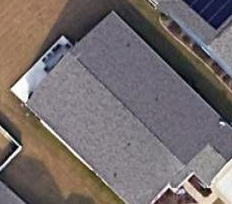

In [76]:
aws_env = False
loaded_image =  None
sample_image_path=os.path.join(ROOT_DIR,'data/xview_building_damage/train/sam_geo/masks','hurricane-florence_00000008_pre_disaster.png')
if aws_env:
    url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
    loaded_image = Image.open(requests.get(url, stream=True).raw)
else:
    loaded_image = Image.open(image)

print(loaded_image.info)
loaded_image

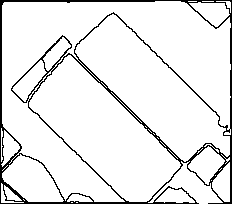

In [156]:
Image.open(sample_image_path)

In [77]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
inputs = processor(images=loaded_image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

In [78]:
print(pixel_values.shape)

torch.Size([1, 3, 224, 224])


### Forward pass

In [79]:
with torch.no_grad():
  outputs = model(pixel_values)
logits = outputs.logits
logits.shape

torch.Size([1, 1000])

In [80]:
prediction = logits.argmax(-1)
print("Predicted class:", model.config.id2label[prediction.item()])

Predicted class: solar dish, solar collector, solar furnace


### Image Preprocessing

In [81]:
def create_image_tiffs(orig_img_dir, img_name, output_dir):
    img_path=os.path.join(orig_img_dir,img_name)
    sample_image = cv2.imread(img_path)
    img_name_wo_ext = img_name.strip('.png')
    cv2.imwrite(os.path.join(output_dir,img_name_wo_ext+'.tif'),sample_image)  

In [82]:
def get_df_with_class_numeric_labels(df_name):
    df_name['damage'].fillna('pre', inplace=True)
    df_name['damage_class']=df_name['damage']
    #train_hurricane_metadata_wo_nans.dropna(inplace=True)
    keys=list(df_name['damage_class'].value_counts().keys())
    df_name['damage_class']=df_name['damage_class'].apply(keys.index)
    df_name['damage_class'].value_counts()
    return df_name

In [83]:
def get_image_polys_df(df_meta):
    return df_meta.groupby('img_name')['image_polygon'].apply(list).reset_index()

In [84]:
def generate_tiff_by_disaster(df_metadata, data_dir, disaster_name, tiffs_output_dir):
    annotations=df_metadata.groupby('img_name')['image_polygon'].apply(list).reset_index()
    image_files_list = list(annotations['img_name'])
    input_path=os.path.join(data_dir, disaster_name)
    print("Started running tiffs creation for : " , disaster_name)
    for img_name in image_files_list:
        print(os.path.join(input_path,'images'))
        create_image_tiffs(os.path.join(input_path,'images'), img_name, tiffs_output_dir)
    print("Finished running tiffs creation for : " , disaster_name)

In [85]:
def prep_data_for_model(df_metadata, data_dir):
    annotations=df_metadata.groupby('img_name')['image_polygon'].apply(list).reset_index()
    image_files_list = list(annotations['img_name'])
    for img_name in image_files_list:
        sample_image = cv2.imread(data_dir + disaster_name + '/images/'+ img_name)
        sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
        images_df = meta_file[meta_file['img_name'] == img_name]
        for idx, img_df in enumerate(images_df['image_polygon']):
            masks, scores, logits = generate_point_mask_sam(img_df)
            mask_name = img_name.strip('.png')+'_'+images_df.iloc[idx]['building_id']+'.png'
            save_mask(masks[np.argmax(scores)],mask_output_dir+mask_name)
    print("Finished mask creation for disaster ",  disaster_name)  



### Generating Tiff Type Images By Disaster

#### Hurrican - Florence

In [86]:
train_hurricane_florence_df= get_df_with_class_numeric_labels(train_hurricane_metadata)
train_hurricane_florence_df.head()
print(train_hurricane_florence_df['damage_class'].value_counts())
print(train_hurricane_florence_df['damage'].value_counts())

damage_class
0    6472
1    4689
2    1245
3     326
4     132
5      54
Name: count, dtype: int64
damage
pre              6472
no-damage        4689
major-damage     1245
un-classified     326
minor-damage      132
destroyed          54
Name: count, dtype: int64


In [ ]:
bd_data_dir=os.path.join(BASE_DATA_DIR, 'xview_building_damage')
train_data_dir = os.path.join(bd_data_dir, 'train')
disaster_name='hurricane-florence'
train_disaster_tifs_dir = os.path.join(train_data_dir, disaster_name, 'tifs')
generate_tiff_by_disaster(train_hurricane_florence_df, train_data_dir, disaster_name, train_disaster_tifs_dir)

#### Other Hurricanes

In [228]:
def pre_process_meta_data(meta_df, out_dir, disaster_name ='hurricane-florence', dataset='train'):
    hc_disaster = meta_df[meta_df['disaster']==disaster_name]
    hc_train = hc_disaster[hc_disaster['dataset']== dataset]
    df_disaster = hc_train[hc_train['image_polygon'].notna()]
    df_disaster['mask_file_names'] = df['img_name'].str.replace('.png', '_')+df['building_id']+'.png'
    df_disaster_class_labels = get_df_with_class_numeric_labels(df_hmc)
    df_disaster_class_labels.to_csv(out_dir+'/hc_'+dataset+"_"+disaster_name+".csv")

In [235]:
xbd_train = os.path.join(BASE_DATA_DIR, 'xview_building_damage', 'train', 'clean_meta_csv')

#### Micheal

In [ ]:
df_all = pd.read_csv(metadata_csv_path)
hc_micheal = df_all[df_all['disaster']=='hurricane-michael']
hc_michael_train = hc_micheal[hc_micheal['dataset']== 'train']
df_hmc = hc_michael_train[hc_michael_train['image_polygon'].notna()]
df_hmc['mask_file_names'] = df_hmc['img_name'].str.replace('.png', '_')+df_hmc['building_id']+'.png'
df_hmc_class_labels = get_df_with_class_numeric_labels(df_hmc)
df_hmc_class_labels['damage'].value_counts()
df_hmc_class_labels.to_csv(xbd_train+'/hmich_meta_train.csv')

In [230]:
pre_process_meta_data(df_all, xbd_train, 'hurricane-michael', 'test')
pre_process_meta_data(df_all, xbd_train, 'hurricane-michael', 'hold')

#### Florence

In [229]:
pre_process_meta_data(df_all, xbd_train, 'hurricane-florence', 'train')

In [232]:
pre_process_meta_data(df_all, xbd_train, 'hurricane-florence', 'test')
pre_process_meta_data(df_all, xbd_train, 'hurricane-florence', 'hold')

#### Matthew

In [233]:
pre_process_meta_data(df_all, xbd_train, 'hurricane-matthew', 'train')
pre_process_meta_data(df_all, xbd_train, 'hurricane-matthew', 'test')
pre_process_meta_data(df_all, xbd_train, 'hurricane-matthew', 'hold')

#### Harvey

In [234]:
pre_process_meta_data(df_all, xbd_train, 'hurricane-harvey', 'train')
pre_process_meta_data(df_all, xbd_train, 'hurricane-harvey', 'test')
pre_process_meta_data(df_all, xbd_train, 'hurricane-harvey', 'hold')

In [ ]:
# train_hh_meta_df=train_metadata.loc[train_metadata['disaster'].isin(['hurricane-harvey'])]
# test_hh_meta_df=test_metadata.loc[test_metadata['disaster'].isin(['hurricane-harvey'])]
# train_hmth_meta_df=train_metadata.loc[train_metadata['disaster'].isin(['hurricane-matthew'])]
# test_hmth_meta_df=test_metadata.loc[test_metadata['disaster'].isin(['hurricane-matthew'])]
# train_hmch_meta_df=train_metadata.loc[train_metadata['disaster'].isin(['hurricane-michael'])]
# test_hmch_meta_df=test_metadata.loc[test_metadata['disaster'].isin(['hurricane-michael'])]

# train_hh_nc_lab_df=get_df_with_class_numeric_labels(train_hh_meta_df)
# train_hmth_nc_lab_df=get_df_with_class_numeric_labels(train_hmth_meta_df)
# train_hmch_nc_lab_df=get_df_with_class_numeric_labels(test_hmch_meta_df)

# df = train_hurricane_florence_df[train_hurricane_florence_df['image_polygon'].notna()]
# df_hh = train_hh_nc_lab_df[train_hh_nc_lab_df['image_polygon'].notna()]
# df_hm = train_hmth_nc_lab_df[train_hmth_nc_lab_df['image_polygon'].notna()]
# df_hmc = train_hmch_nc_lab_df[train_hmch_nc_lab_df['image_polygon'].notna()]
# train_data_dir = os.path.join(bd_data_dir, 'train')

# df['mask_file_names'] = df['img_name'].str.replace('.png', '_')+df['building_id']+'.png'
# df_hh['mask_file_names'] = df_hh['img_name'].str.replace('.png', '_')+df_hh['building_id']+'.png'
# df_hm['mask_file_names'] = df_hm['img_name'].str.replace('.png', '_')+df_hm['building_id']+'.png'
# df_hmc['mask_file_names'] = df_hmc['img_name'].str.replace('.png', '_')+df_hmc['building_id']+'.png'

# #data/xview_building_damage/train/clean_meta_csvs

# df.to_csv(xbd_train+'/hf_meta_train.csv')
# df_hh.to_csv(xbd_train+'/hh_meta_train.csv')
# df_hm.to_csv(xbd_train+'/hm_meta_train.csv')


### Generating Tiles Images for individual buildings

In [ ]:
dis_name = 'hurricane-harvey'
train_disaster_tifs_dir = os.path.join(train_data_dir, dis_name, 'tifs')
generate_tiff_by_disaster(train_hh_nc_lab_df, train_data_dir, dis_name, train_disaster_tifs_dir)

In [ ]:
dis_name = 'hurricane-matthew'
train_disaster_tifs_dir = os.path.join(train_data_dir, dis_name, 'tifs')
generate_tiff_by_disaster(train_hmth_nc_lab_df, train_data_dir, dis_name, train_disaster_tifs_dir)

In [ ]:
dis_name = 'hurricane-michael'
train_disaster_tifs_dir = os.path.join(train_data_dir, dis_name, 'tifs')
generate_tiff_by_disaster(train_hmch_nc_lab_df, train_data_dir, dis_name, train_disaster_tifs_dir)

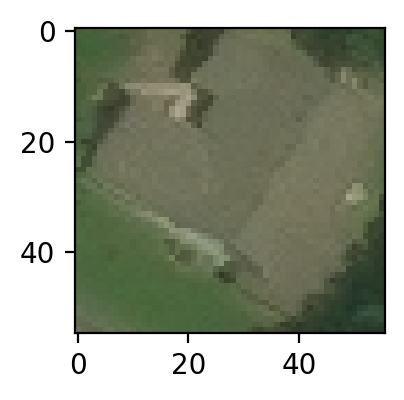

In [91]:
img_nm='hurricane-florence_00000015_pre_disaster.tif'
out_name='output.tif'
train_data_dir = os.path.join(bd_data_dir, 'train')
train_disaster_tifs_dir = os.path.join(train_data_dir, 'hurricane-florence', 'tifs')
input_path = os.path.join(train_disaster_tifs_dir,img_nm)
out_path=os.path.join(train_data_dir, 'hurricane-florence', out_name)
map_b=get_bounds_tp('POLYGON ((-77.88107249915639 34.60174844403493, -77.88098874614532 34.60180287433197, -77.88092735717723 34.60181612648822, -77.88087035888097 34.60172699517501, -77.8808762441666 34.60171374332619, -77.88101215058224 34.60165414685003, -77.88107249915639 34.60174844403493))')
bbox = get_bounds_tp('POLYGON ((749.3385911021327 382.8597387895979, 769.0079390854055 391.6157711194367, 779.1020387059676 400.2914711701138, 771.118655669168 415.9249881796352, 776.4949812210343 419.7873533925342, 766.3430596825572 437.9339131443713, 723.1973931366729 410.3968259685066, 733.0955166399604 394.6613475812835, 744.6433273888493 401.5138946224681, 748.0696009096962 395.4227416957306, 743.3743371966666 392.1233671974258, 749.3385911021327 382.8597387895979))')
im=Image.open(input_path)
im=im.crop(bbox)
im.save(out_path)
plt.figure(figsize=(2,2))
plt.imshow(im)  

In [180]:
def create_and_save_building_tiles(meta_df, bd_data_dir, disaster_name, output_dir_name):
    train_data_dir = os.path.join(bd_data_dir, 'train')
    train_disaster_tifs_dir = os.path.join(train_data_dir, disaster_name, 'tifs')
    annotations=get_image_polys_df(meta_df)
    image_files_list = list(annotations['img_name'])
    input_path=os.path.join(bd_data_dir, disaster_name, 'tifs')
    #print(input_path)
    out_path=os.path.join(train_data_dir, disaster_name, output_dir_name )
    print("Starting to crop building tile for disaster", disaster_name)
    for img_name in image_files_list:
        images_df = meta_df[meta_df['img_name'] == img_name]
        img_nm=img_name.strip('.png')+'.tif'
        img_path=os.path.join(train_disaster_tifs_dir,img_nm)
        if os.path.exists(img_path):
            for idx, img_df in enumerate(images_df['image_polygon']):
                out_name=img_name.strip('.png')+'_'+str(images_df.iloc[idx]['building_id'])+'.tif'
                build_crop_path=os.path.join(out_path,out_name)
                #print(out_name)
                #print(images_df.iloc[idx]['image_polygon'])
                bbox = get_bounds_tp(images_df.iloc[idx]['image_polygon'])
                im=Image.open(img_path)
                im=im.crop(bbox)
                im.save(build_crop_path)
        else:
            print(" Image with name ",img_nm, " does not exists")
    print("Finished to crop building tile for disaster", disaster_name)

In [305]:
bd_data_dir=os.path.join(BASE_DATA_DIR, 'xview_building_damage')
disaster_name='hurricane-florence'
create_and_save_building_tiles(df, bd_data_dir, disaster_name, 'building_crops')

Starting to crop building tile for disaster hurricane-florence
Finished to crop building tile for disaster hurricane-florence


In [319]:
disaster_name='hurricane-harvey'
create_and_save_building_tiles(df_hh, bd_data_dir, disaster_name, 'building_crops')

Starting to crop building tile for disaster hurricane-harvey
Finished to crop building tile for disaster hurricane-harvey


In [320]:
disaster_name='hurricane-matthew'
create_and_save_building_tiles(df_hm, bd_data_dir, disaster_name, 'building_crops')

Starting to crop building tile for disaster hurricane-matthew
Finished to crop building tile for disaster hurricane-matthew


In [336]:
disaster_name='hurricane-michael'
create_and_save_building_tiles(df_hmc, bd_data_dir, disaster_name, 'building_crops')

Starting to crop building tile for disaster hurricane-michael
Finished to crop building tile for disaster hurricane-michael


In [338]:
BASE_DATA_DIR

'/Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data'

In [345]:
output_dir = os.path.join(ROOT_DIR,'data/xview_building_damage/train/sam_geo/masks','hurricane-florence_00000008_pre_disaster.png' )

#mask = os.path.join(ROOT_DIR,'data/xview_building_damage/train/masks','07d9940d-cd23-4973-a229-ce5de23c978c.tif' )
sample_image = os.path.join(BASE_DATA_DIR,'xview_building_damage/train/hurricane-harvey/building_crops/', 'hurricane-harvey_00000000_post_disaster_07d9940d-cd23-4973-a229-ce5de23c978c.tif')
sam_geo.generate(
    output=output_dir, source=sample_image, batch=True, foreground=True, erosion_kernel=(3, 3), mask_multiplier=255
)

100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.89s/it]


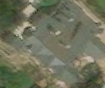

In [340]:
Image.open(sample_image)

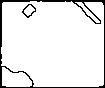

In [346]:
Image.open(output_dir)

#### Custom Data Class

In [139]:
class CustomBuildingDamage(Dataset):
    def __init__(self, meta_df, data_dir, disaster_name, transform = None):
      # set root directory for your dataset
      self.meta_df = meta_df
      self.data_dir = data_dir  
      self.transform = transform

    def __len__(self):
      return len(self.meta_df)

    def __getitem__(self, i):
      image_filename = self.meta_df.iloc[i]['img_name'].strip('.png')+'_'+self.meta_df.iloc[i]['building_id']+'.png'
      image_path = os.path.join(self.data_dir  , image_filename)
      #image = io.imread(image_path) 
      image = Image.open(image_path) 
      class_name = self.meta_df.iloc[i]['damage']
      class_numeric = self.meta_df.iloc[i]['damage_class']
      sample =   {'img' :image, 'class':class_name, 'label' : class_numeric }

      if self.transform :
          sample=self.transform(sample)
    
      return sample

In [155]:
disaster_name = 'hurricane-matthew'
bd_dir=os.path.join(BASE_DATA_DIR, 'xview_building_damage')
challeng_dir = os.path.join(bd_dir, 'challenge')
out_dir=os.path.join(challeng_dir, 'output')
disaster_dir = os.path.join(out_dir, disaster_name)
post_mask=os.path.join(disaster_dir, 'post_masks')

mask_bd_dataset = CustomBuildingDamage(meta_df = df_hm, data_dir=post_mask, disaster_name=disaster_name)

### Data Loader - Pytorch

In [94]:
train_hmth_nc_lab_df['mask_file'] = train_hmth_nc_lab_df['img_name'].str.replace('.png', '_')+train_hmth_nc_lab_df['building_id']+'.png'

In [237]:
#### This is needed by VIT
def move_masks_by_class(top_dir, meta_df, disaster_name='hurricane-michael', post=True):
    root_path=os.path.join(top_dir, disaster_name)
    disas_post_mask= os.path.join(root_path, 'post_masks') #source
    print("Source root : ", disas_post_mask)
    disas_class_path=os.path.join(root_path, 'class', 'post')
    print("Destination root : ", disas_class_path)
    print("Started moving the mask files to class folder for ", disaster_name)
    for idx, file_name in enumerate(meta_df['mask_file_names']):
        source = os.path.join(disas_post_mask, meta_df.iloc[idx]['mask_file_names'])
        #print(source)
        destination = os.path.join(disas_class_path, meta_df.iloc[idx]['damage'])
        if not os.path.exists(destination):
            os.mkdir(destination)
        if os.path.exists(source):
            #print("Exist")
            shutil.move(source, destination)
        else:
            print("Image with name ", meta_df.iloc[idx]['mask_file_names'], " does not exists")
    print("Finshed moving the mask files to class folder for ", disaster_name)

In [238]:
#print(out_dir)
move_masks_by_class(out_dir, df_hmc_class_labels, 'hurricane-michael')

Source root :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/output/hurricane-michael/post_masks
Destination root :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/output/hurricane-michael/class/post
Started moving the mask files to class folder for  hurricane-michael
Image with name  hurricane-michael_00000000_pre_disaster_dc6cb95a-4105-4cff-ae51-562fe8b949e5.png  does not exists
Image with name  hurricane-michael_00000000_pre_disaster_152dd777-6e62-4b81-b479-e2ab99c4b4a6.png  does not exists
Image with name  hurricane-michael_00000000_pre_disaster_e5773672-0fef-49c9-a4e9-34f00b33fe07.png  does not exists
Image with name  hurricane-michael_00000000_pre_disaster_0671bfa2-a8b7-4b40-a627-e3281ddaee35.png  does not exists
Image with name  hurricane-michael_00000000_pre_disaster_f43e3b5a-4732-4d75-802a-de31b56eb5da.png  does not exists
Image with name  hu

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Prepare Model and Data

In [4]:
imagenet_labels = dict(enumerate(open('/Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/train/sample.txt')))

In [108]:
model_name = "vit_base_patch16_224"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
# create a ViT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
model = create_model(model_name, pretrained=True).to(device)

device =  cpu


In [110]:
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [117]:

#img = Image.open('/Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/output/hurricane-florence/post_masks/hurricane-florence_00000000_post_disaster_e452a5df-e16a-4ff9-897e-b55545e74b2e.png')
#orig_image=Image.open('/Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/output/hurricane-florence/images/hurricane-florence_00000000_post_disaster.png')

mask = cv2.imread('/Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/output/hurricane-florence/post_masks/hurricane-florence_00000000_post_disaster_e452a5df-e16a-4ff9-897e-b55545e74b2e.png')
orig_image=cv2.imread('/Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/output/hurricane-florence/images/hurricane-florence_00000000_post_disaster.png')

In [111]:
dict_labels={'img':'hurricane-florence_00000000_post_disaster_e452a5df-e16a-4ff9-897e-b55545e74b2e.png', 'label':0}
img_tensor = transforms(img).unsqueeze(0).to(device)

In [112]:
output = model(img_tensor)
#print(output)

Inference Result:
nematode, nematode_worm, roundworm



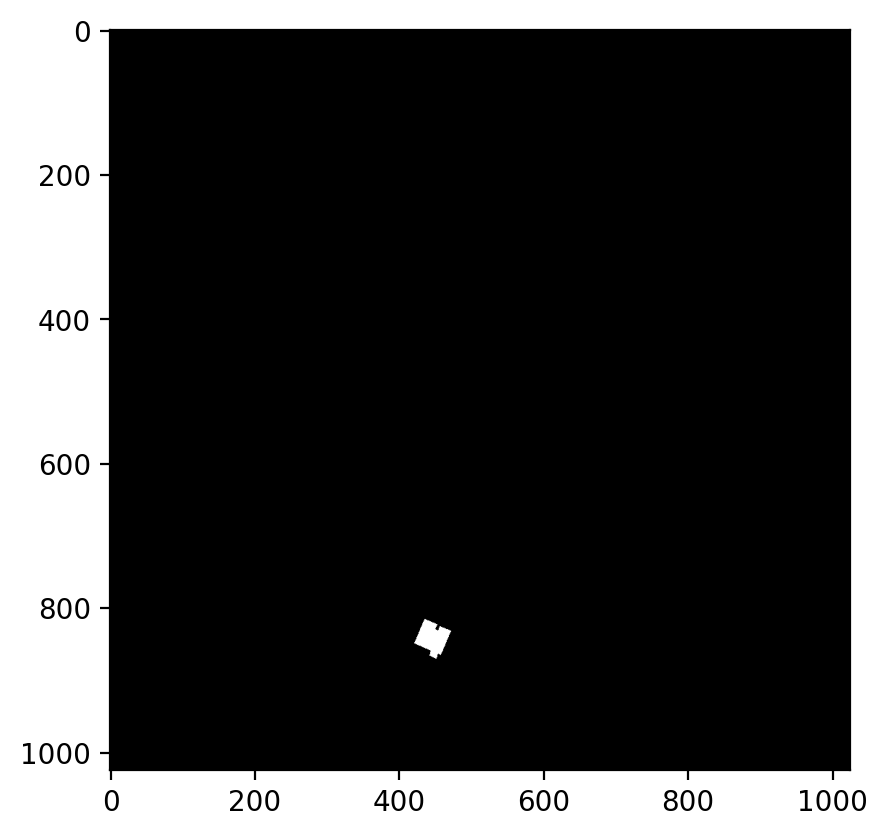

In [119]:
print("Inference Result:")
print(imagenet_labels[int(torch.argmax(output))])
plt.imshow(img)

In [22]:
#Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
patches = model.patch_embed(img_tensor)  # patch embedding convolution
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", patches.shape)

Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings:  torch.Size([1, 196, 768])


### 1. Splitting Image into Patches

In [23]:
patches = model.patch_embed(img_tensor)  # patch embedding convolution
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", patches.shape)

Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings:  torch.Size([1, 196, 768])


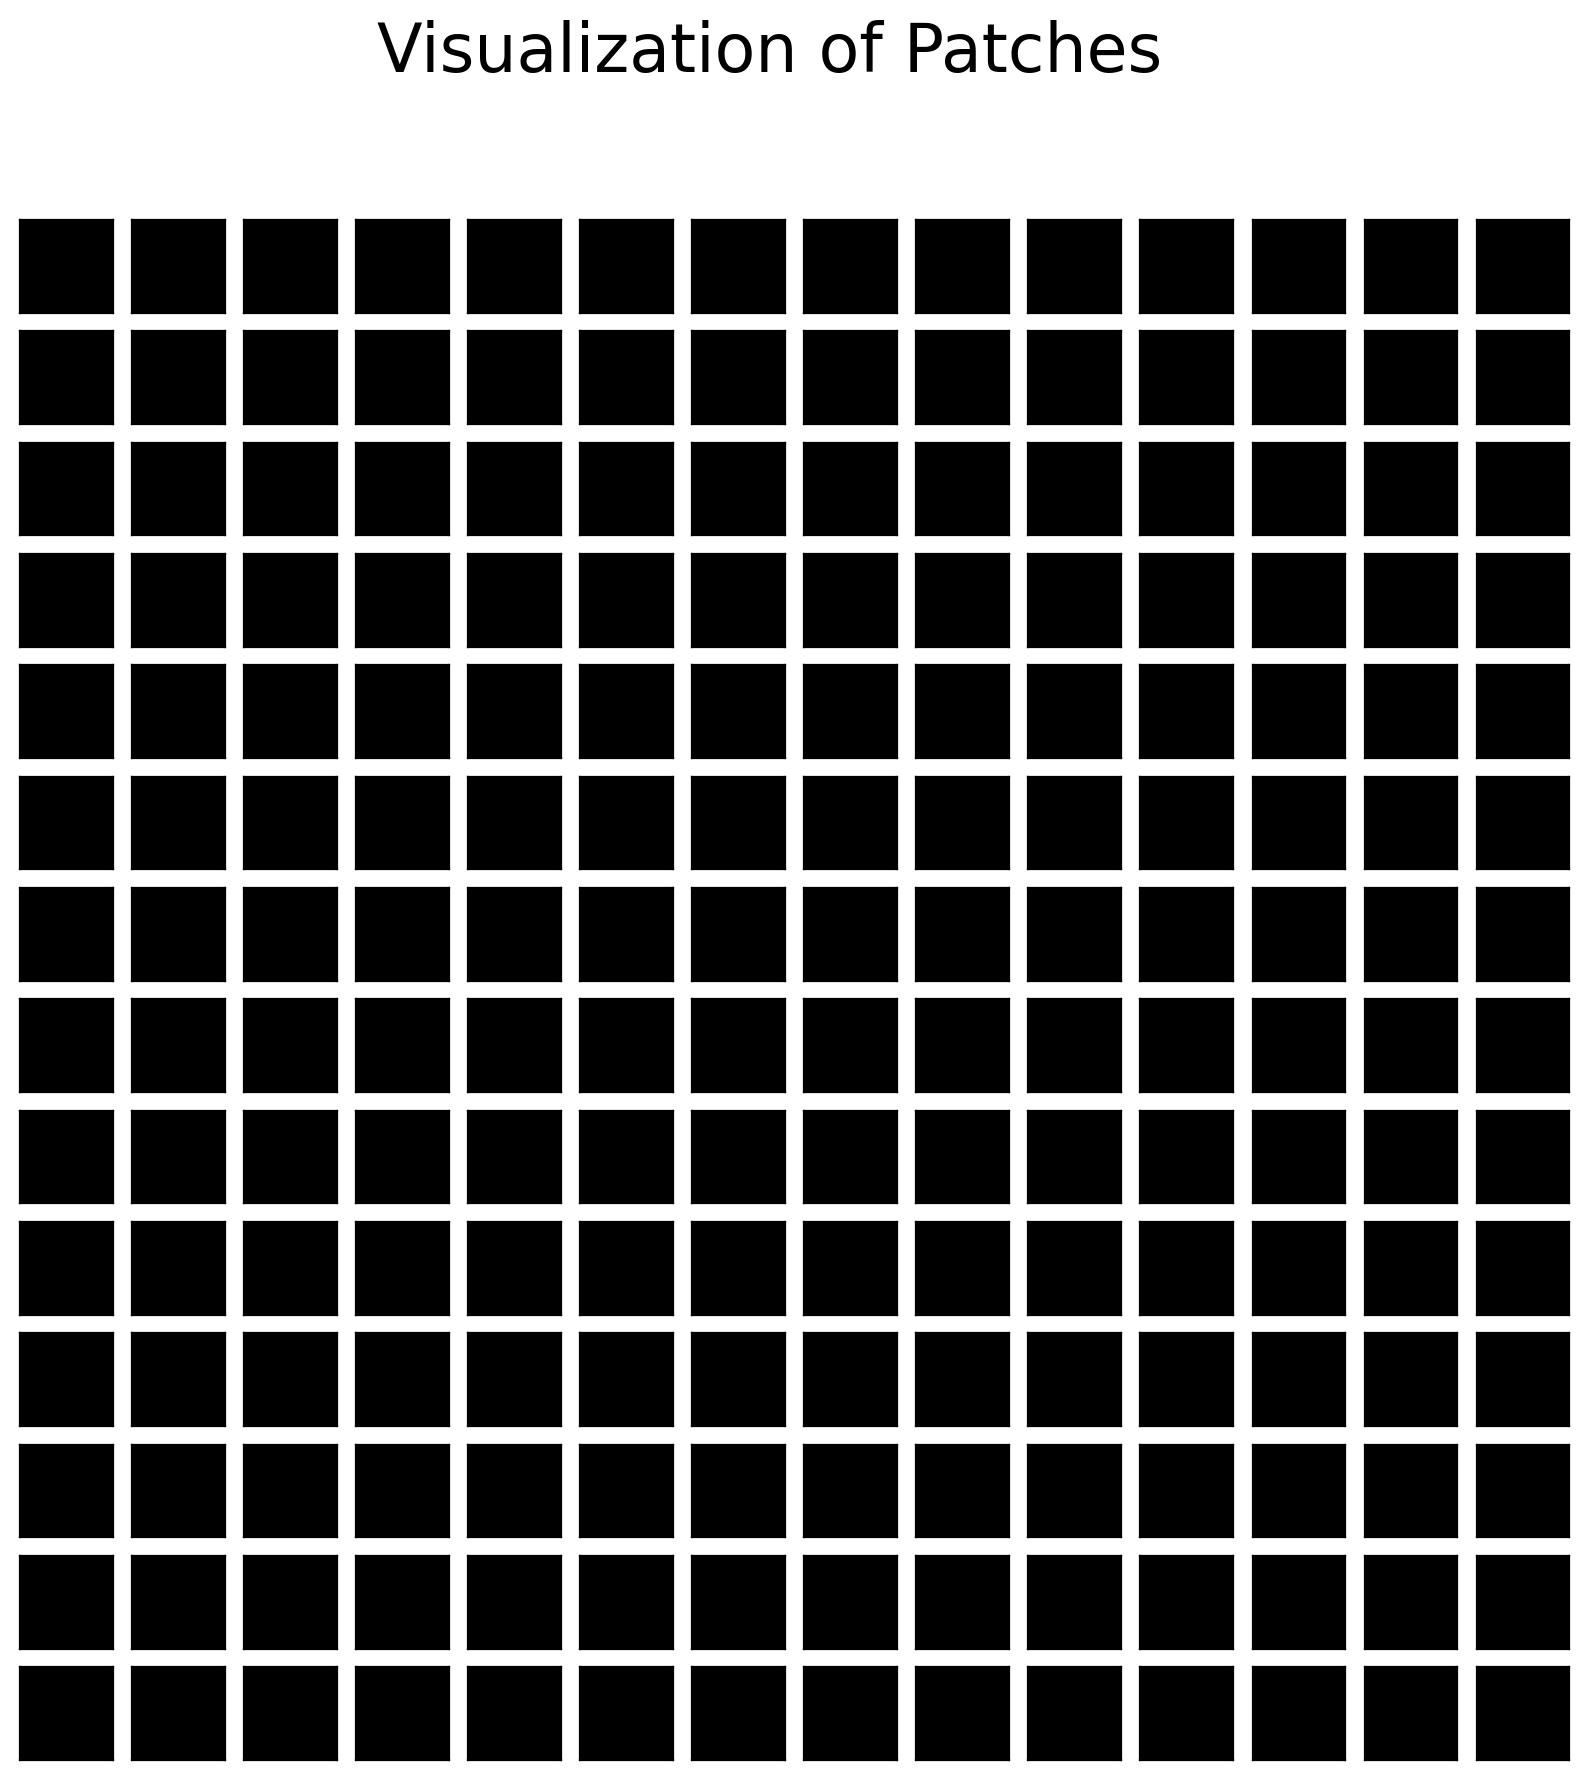

In [24]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle("Visualization of Patches", fontsize=24)
img = np.asarray(img)
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

### 2. Add Position Embeddings

In [25]:
pos_embed = model.pos_embed
print(pos_embed.shape)

torch.Size([1, 197, 768])


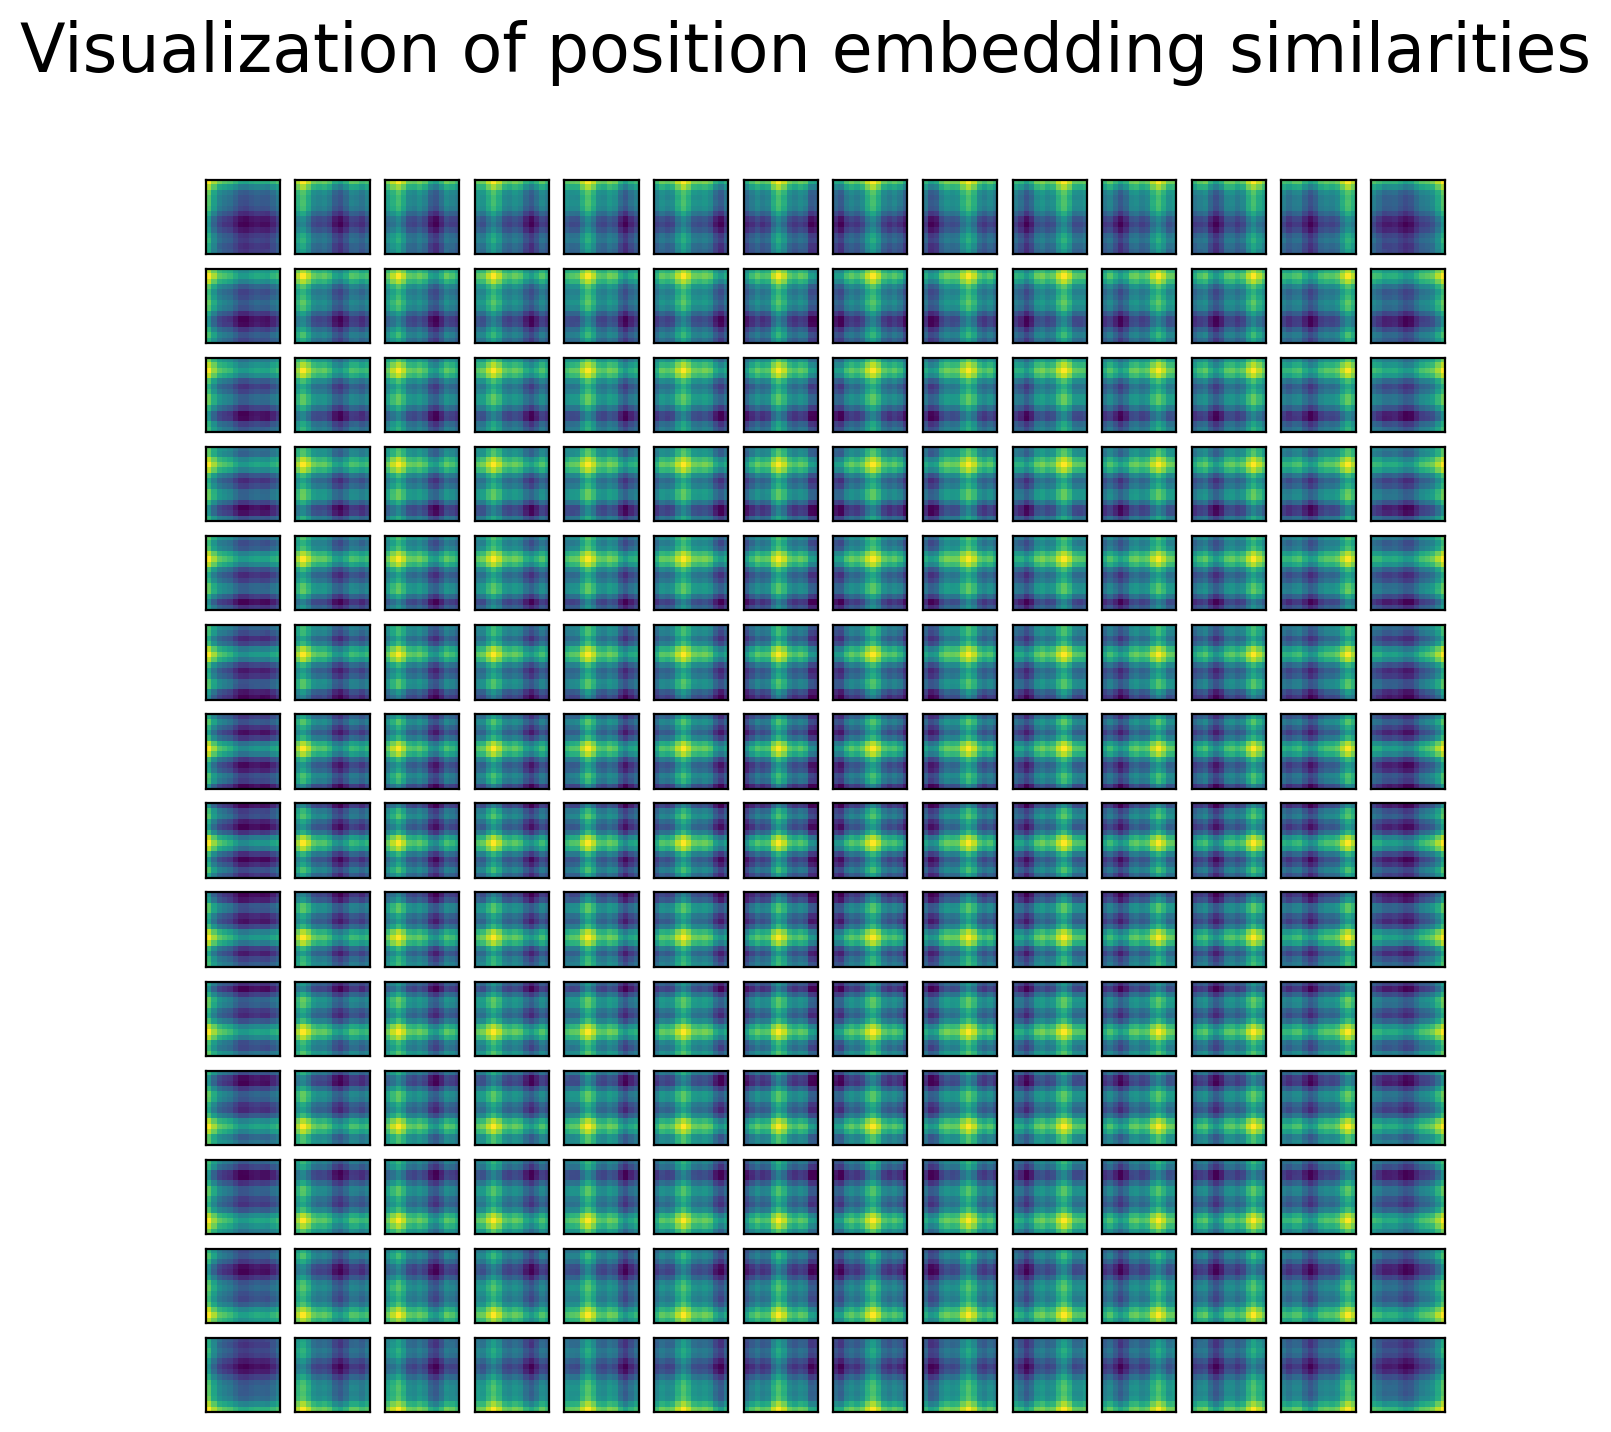

In [26]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=24)
for i in range(1, pos_embed.shape[1]):
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

### Make Transformation Input

In [27]:
transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
print("Transformer input: ", transformer_input.shape)

Transformer input:  torch.Size([1, 197, 768])


### Transformer Encoder

In [28]:
print("Input tensor to Transformer (z0): ", transformer_input.shape)
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
    print("Entering the Transformer Encoder {}".format(i))
    x = blk(x)
x = model.norm(x)
transformer_output = x[:, 0]
print("Output vector from Transformer (z12-0):", transformer_output.shape)

Input tensor to Transformer (z0):  torch.Size([1, 197, 768])
Entering the Transformer Encoder 0
Entering the Transformer Encoder 1
Entering the Transformer Encoder 2
Entering the Transformer Encoder 3
Entering the Transformer Encoder 4
Entering the Transformer Encoder 5
Entering the Transformer Encoder 6
Entering the Transformer Encoder 7
Entering the Transformer Encoder 8
Entering the Transformer Encoder 9
Entering the Transformer Encoder 10
Entering the Transformer Encoder 11
Output vector from Transformer (z12-0): torch.Size([1, 768])


### Attention Layer

In [29]:
print("Transformer Multi-head Attention block:")
attention = model.blocks[0].attn
print(attention)
print("input of the transformer encoder:", transformer_input.shape)

Transformer Multi-head Attention block:
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (q_norm): Identity()
  (k_norm): Identity()
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
input of the transformer encoder: torch.Size([1, 197, 768])


In [30]:
transformer_input_expanded = attention.qkv(transformer_input)[0]
print("expanded to: ", transformer_input_expanded.shape)

expanded to:  torch.Size([197, 2304])


In [31]:
qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  # (N=197, (qkv), H=12, D/H=64)
print("split qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
print("transposed ks: ", kT.shape)

split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


attention matrix:  torch.Size([12, 197, 197])


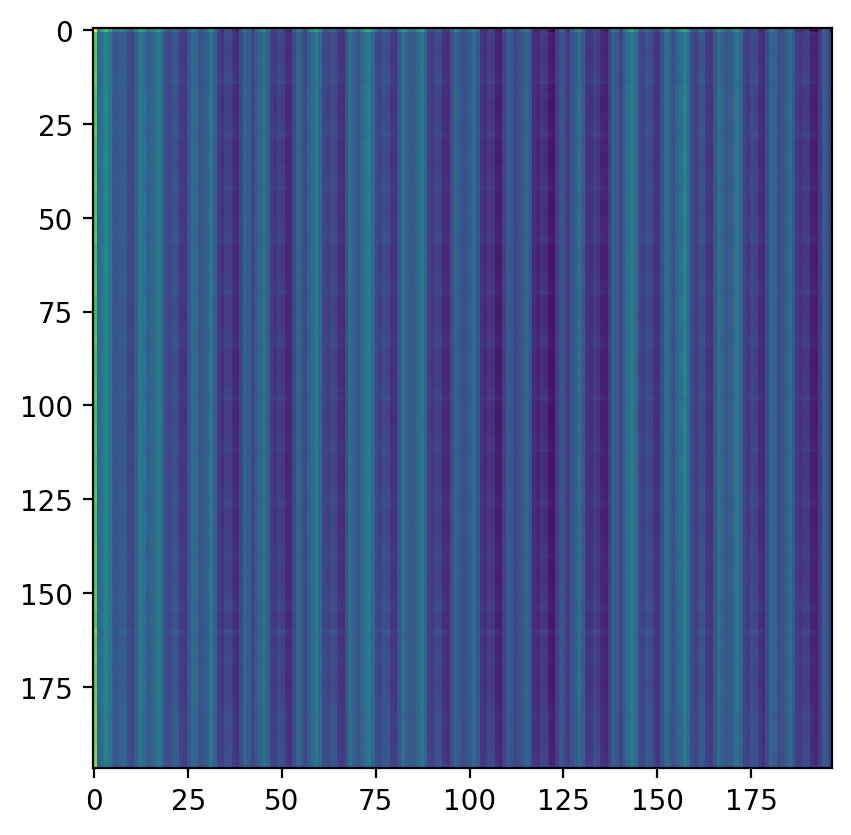

In [32]:
attention_matrix = q @ kT
print("attention matrix: ", attention_matrix.shape)
plt.imshow(attention_matrix[3].detach().cpu().numpy())

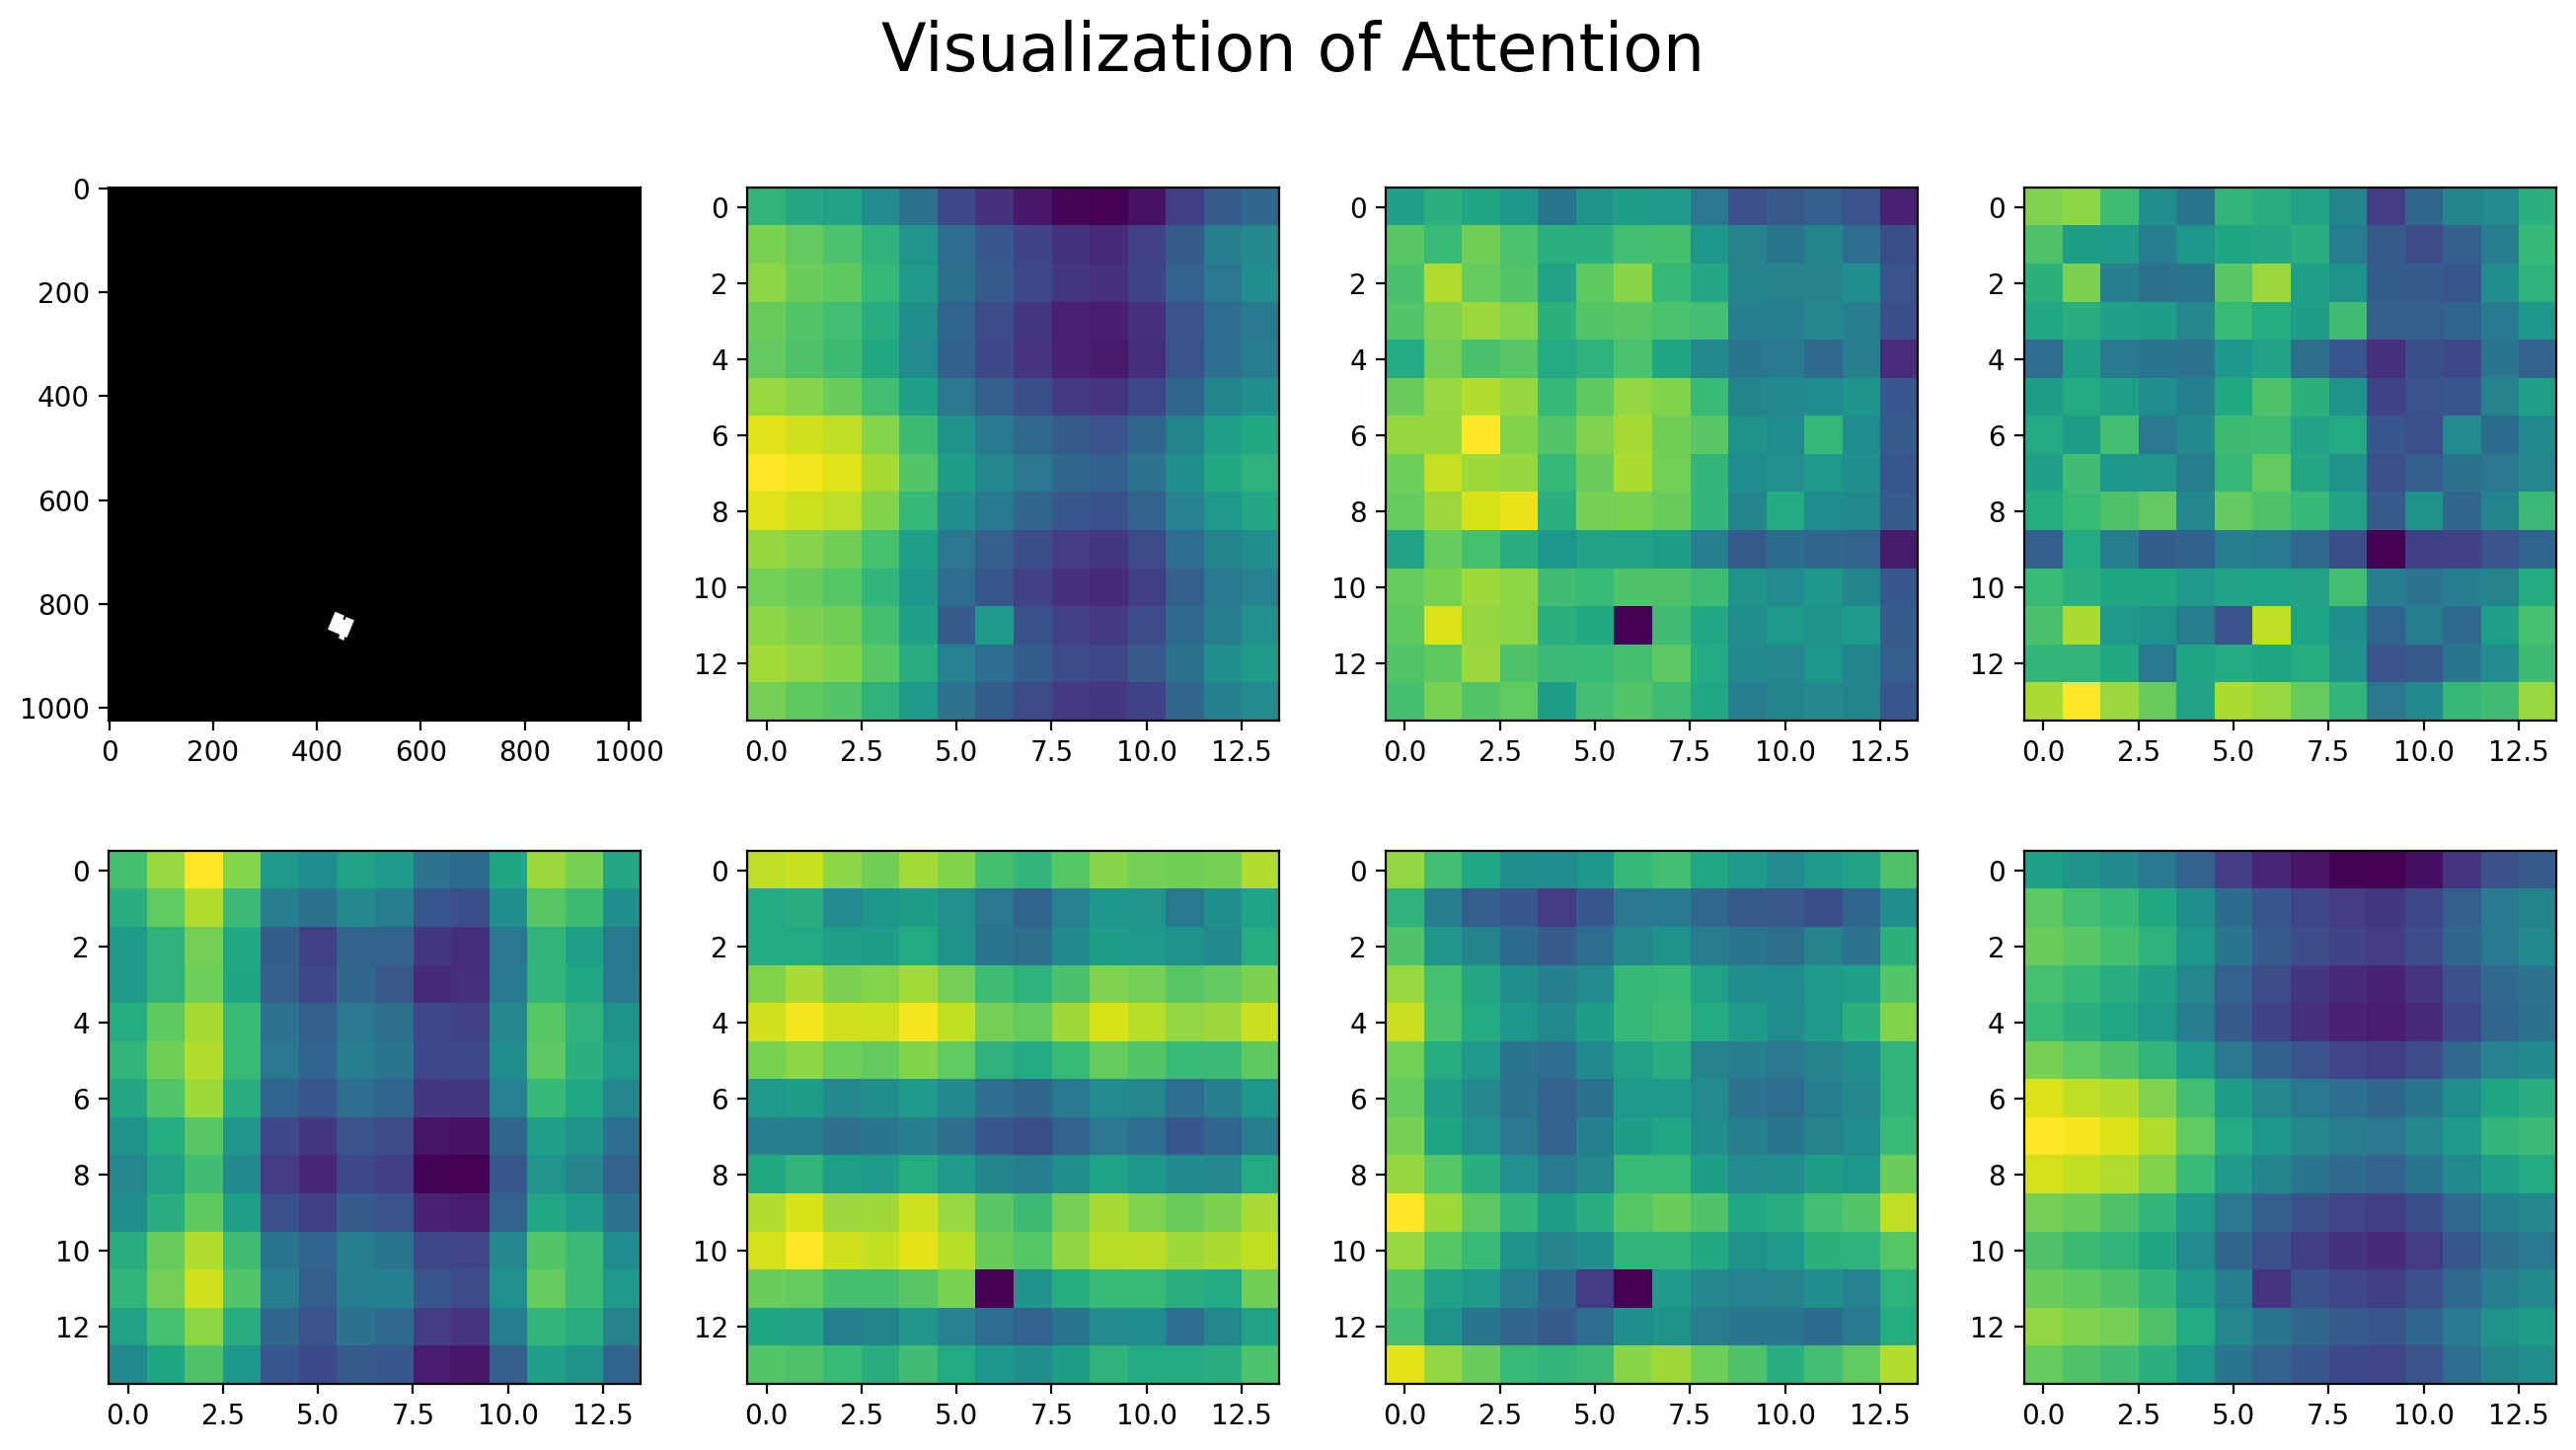

In [33]:
# Visualize attention matrix
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of Attention", fontsize=24)
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
for i in range(7):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, 100, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(attn_heatmap)

### 4. MLP (Classification) Head

Classification head:  Linear(in_features=768, out_features=1000, bias=True)
Inference result : id = 111, label name = nematode, nematode_worm, roundworm



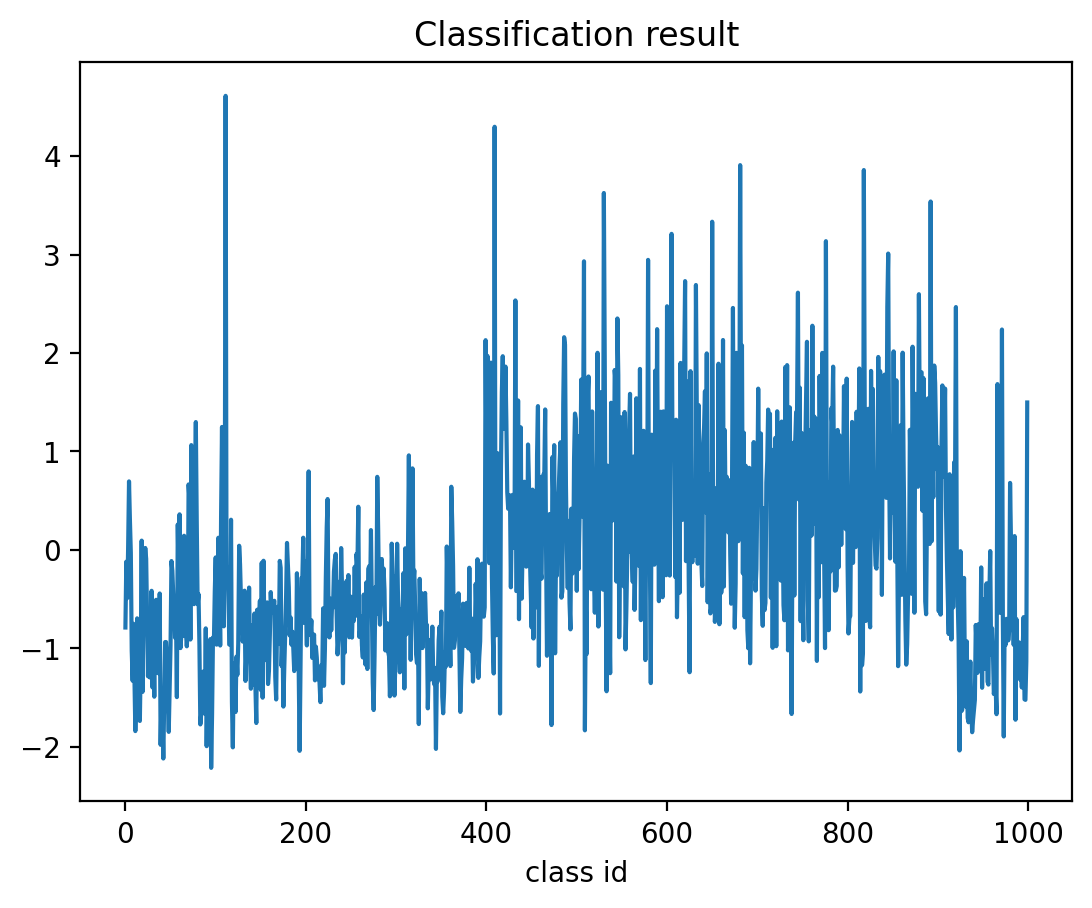

In [34]:
print("Classification head: ", model.head)
result = model.head(transformer_output)
result_label_id = int(torch.argmax(result))
plt.plot(result.detach().cpu().numpy()[0])
plt.title("Classification result")
plt.xlabel("class id")
print("Inference result : id = {}, label name = {}".format(
    result_label_id, imagenet_labels[result_label_id]))